# Jigsaw Unintended Bias in Toxicity Classification

In [2]:
# autoreload function - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import collections
import csv
import pandas as pd
import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt

In [4]:
from run_classifier import *

import modeling
import optimization
import tokenization


In [5]:
start_time = time.time()

# assumes that our train and test data is in the directory above

df = pd.read_csv('../train.csv')
df_test = pd.read_csv('../test.csv')
print('loading finished in {:.1f}s'.format(time.time()-start_time))

loading finished in 13.0s


In [6]:
train = pd.read_csv('../train.csv')
test = pd.read_csv('../test.csv')

In [9]:
train['comment_text'] = train['comment_text'].replace({r'\s+$': '', r'^\s+': ''}, regex=True).replace(r'\n',  ' ', regex=True)
test['comment_text'] = test['comment_text'].replace({r'\s+$': '', r'^\s+': ''}, regex=True).replace(r'\n',  ' ', regex=True)

In [10]:
# padding the 
train['dummy_1'] = 'meh'
train['dummy_2'] = '*'

# rebinding for "cola format"
# it is somewhat unclear why we currently do this
train = train[['dummy_1','target','dummy_2','comment_text']]

# setting up the binary classifier in the target file
train['target'] = np.where(train['target']>=0.5,1,0)

In [20]:
# resampling (maybe something we can tune when testing out new architectures)
train = train.sample(frac=0.02)

In [21]:
#export as tab seperated

train.to_csv('train.tsv', sep='\t', index=False, header=False)
test.to_csv('test.tsv', sep='\t', index=False, header=True)

In [13]:
# define "task" format (this is a BERT parameter)
task_name = 'cola'

In [7]:
# define bert checkpoint (this loads in the initial weights for BERT)
bert_config_file = '../uncased_L-12_H-768_A-12/bert_config.json'
vocab_file = '../uncased_L-12_H-768_A-12/vocab.txt'
init_checkpoint = '../uncased_L-12_H-768_A-12/bert_model.ckpt'

In [8]:
# define directories for where the tsv files are held
data_dir = './'
output_dir = './'

In [2]:
# define all the additional parameters (some hardware, some model)
do_lower_case = False
max_seq_length = 128
do_train = True
do_eval = False
do_predict = False
train_batch_size = 32
eval_batch_size = 32
predict_batch_size = 32
learning_rate = 2e-5 
num_train_epochs = 1.0
warmup_proportion = 0.1
use_tpu = False # we need to change this parameter
master = None
save_checkpoints_steps = 99999999 # <----- don't want to save any checkpoints
iterations_per_loop = 1000
num_tpu_cores = 1
tpu_cluster_resolver = None

In [10]:
start = time.time()
print("--------------------------------------------------------")
print("Starting training ...")
print("--------------------------------------------------------")

--------------------------------------------------------
Starting training ...
--------------------------------------------------------


In [11]:
bert_config = modeling.BertConfig.from_json_file(bert_config_file)

processor = ColaProcessor()
label_list = processor.get_labels()

tokenizer = tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

tpu_cluster_resolver = None
is_per_host = tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2

run_config = tf.contrib.tpu.RunConfig(
  cluster=tpu_cluster_resolver,
  master=master,
  model_dir=output_dir,
  save_checkpoints_steps=save_checkpoints_steps,
  tpu_config=tf.contrib.tpu.TPUConfig(
      iterations_per_loop=iterations_per_loop,
      num_shards=num_tpu_cores,
      per_host_input_for_training=is_per_host))

train_examples = processor.get_train_examples(data_dir)
num_train_steps = int(len(train_examples) / train_batch_size * num_train_epochs)
num_warmup_steps = int(num_train_steps * warmup_proportion)

model_fn = model_fn_builder(
      bert_config=bert_config,
      num_labels=len(label_list),
      init_checkpoint=init_checkpoint,
      learning_rate=learning_rate,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      use_tpu=use_tpu,
      use_one_hot_embeddings=use_tpu)

estimator = tf.contrib.tpu.TPUEstimator(
      use_tpu=use_tpu,
      model_fn=model_fn,
      config=run_config,
      train_batch_size=train_batch_size)
      
      
train_file = os.path.join(output_dir, "train.tf_record")

file_based_convert_examples_to_features(
    train_examples, label_list, max_seq_length, tokenizer, train_file)

tf.logging.info("***** Running training *****")
tf.logging.info("  Num examples = %d", len(train_examples))
tf.logging.info("  Batch size = %d", train_batch_size)
tf.logging.info("  Num steps = %d", num_train_steps)

train_input_fn = file_based_input_fn_builder(
    input_file=train_file,
    seq_length=max_seq_length,
    is_training=True,
    drop_remainder=True)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Using config: {'_model_dir': './', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 99999999, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0xb476664a8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_nu

In [ ]:
# final method to train
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running train on CPU
INFO:tensorflow:*** Features ***
INFO:tensorflow:  name = input_ids, shape = (32, 72)
INFO:tensorflow:  name = input_mask, shape = (32, 72)
INFO:tensorflow:  name = is_real_example, shape = (32,)
INFO:tensorflow:  name = label_ids, shape = (32,)
INFO:tensorflow:  name = segment_ids, shape = (32, 72)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.
INFO:tensorflow:**** Trainable Variables ****
INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*
INFO:tensorflo

INFO:tensorflow:  name = bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_3/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tenso

INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./model.ckpt.


In [1]:
end = time.time()
print("--------------------------------------------------------")
print("Training complete in ", end - start, " seconds")
print("--------------------------------------------------------")

NameError: name 'time' is not defined

In [6]:
df.head(5)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [7]:
def split_target(x):
    if x == 0:
        return 0
    elif 0 < x <= 0.25:
        return 0.25
    elif 0.25 < x <= 0.5:
        return 0.5
    elif 0.5 < x <= 0.75:
        return 0.75
    else:
        return 1

In [8]:
df['label'] = df['target'].apply(split_target)

In [9]:
df.label.value_counts().index.values

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [10]:
df.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count', 'label'],
      dtype='object')

In [11]:
df.dtypes.value_counts()

float64    33
int64      10
object      3
dtype: int64

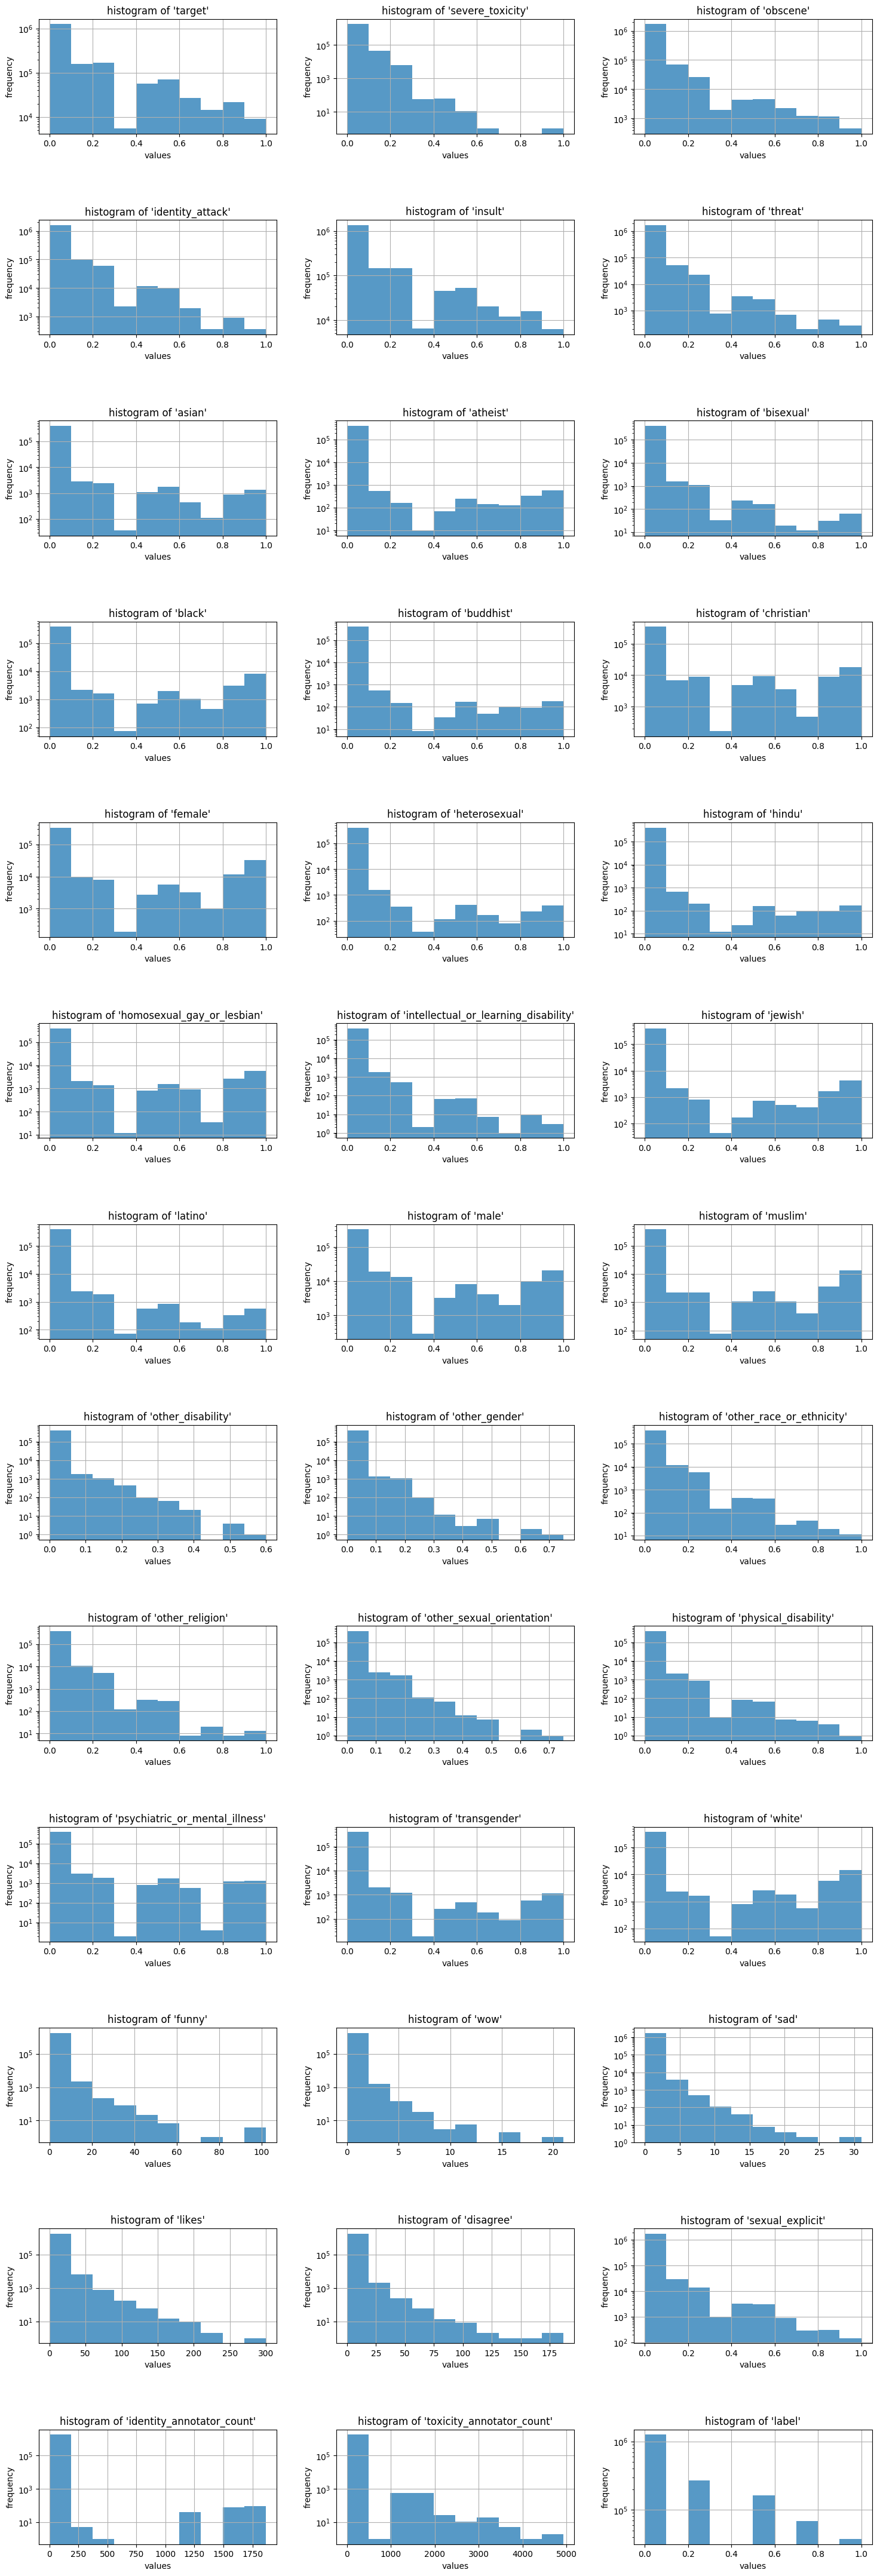

plotting finished in 16.1s


In [12]:
start_time = time.time()
fig, ax = plt.subplots(13, 3, figsize=(6*3,4*14), dpi=100)

i = 0
j = 0
for c in df.columns:
    types = ['float64', 'int64']
    if df[c].dtypes in types and (c != 'id' and '_id' not in c):
        ax[i][j].hist(df[c].dropna(), log=True, alpha=0.75)
        if np.max(df[c]) > 5000:
            ax[i][j].tick_params(axis='x', labelrotation=90)
        ax[i][j].set_xlabel('values')
        ax[i][j].set_ylabel('frequency')
        ax[i][j].set_title("histogram of '{}'".format(c))
        ax[i][j].grid(True)
        if j == 2:
            i += 1
            j = 0
        else:
            j += 1
plt.subplots_adjust(wspace=0.25, hspace=0.75)
plt.show()
print('plotting finished in {:.1f}s'.format(time.time()-start_time))

## Data Preprocessing

In [13]:
OUTPUT_DIR = 'output'#@param {type:"string"}
#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = False #@param {type:"boolean"}

if DO_DELETE:
    try:
        tf.gfile.DeleteRecursively(OUTPUT_DIR)
    except:
        # Doesn't matter if the directory didn't exist
        pass
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: output *****


In [14]:
training_frac = 0.8
train_len = int(len(df)*training_frac)
valid_len = int(len(df)*(1-training_frac))

df_train = df.iloc[:train_len, :]
df_valid = df.iloc[:valid_len, :]

print(len(df_train))
print(len(df_valid))

1443899
360974


In [15]:
df['comment_text'][0]

"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!"

In [16]:
start_time = time.time()
DATA_COLUMN = 'comment_text'
LABEL_COLUMN = 'label'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
label_list = df.label.value_counts().index.values

train_InputExamples = df_train.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

valid_InputExamples = df_valid.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)
print('processing finished in {:.1f}s'.format(time.time()-start_time))

processing finished in 50.3s


In [17]:
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    with tf.Graph().as_default():
        bert_module = hub.Module(BERT_MODEL_HUB)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        with tf.Session() as sess:
            vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"], tokenization_info["do_lower_case"]])
    return bert.tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

Instructions for updating:
Colocations handled automatically by placer.


W0513 00:31:03.718844 139896851691264 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 00:31:05.438821 139896851691264 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [18]:
print(tokenizer.tokenize(df['comment_text'][0]))

['this', 'is', 'so', 'cool', '.', 'it', "'", 's', 'like', ',', "'", 'would', 'you', 'want', 'your', 'mother', 'to', 'read', 'this', '?', '?', "'", 'really', 'great', 'idea', ',', 'well', 'done', '!']


In [19]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, 
                                                                  MAX_SEQ_LENGTH, tokenizer)
valid_features = bert.run_classifier.convert_examples_to_features(valid_InputExamples, label_list, 
                                                                  MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 1443899


I0513 00:31:06.731681 139896851691264 run_classifier.py:774] Writing example 0 of 1443899


INFO:tensorflow:*** Example ***


I0513 00:31:06.733222 139896851691264 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0513 00:31:06.734019 139896851691264 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] this is so cool . it ' s like , ' would you want your mother to read this ? ? ' really great idea , well done ! [SEP]


I0513 00:31:06.734823 139896851691264 run_classifier.py:464] tokens: [CLS] this is so cool . it ' s like , ' would you want your mother to read this ? ? ' really great idea , well done ! [SEP]


INFO:tensorflow:input_ids: 101 2023 2003 2061 4658 1012 2009 1005 1055 2066 1010 1005 2052 2017 2215 2115 2388 2000 3191 2023 1029 1029 1005 2428 2307 2801 1010 2092 2589 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:31:06.735657 139896851691264 run_classifier.py:465] input_ids: 101 2023 2003 2061 4658 1012 2009 1005 1055 2066 1010 1005 2052 2017 2215 2115 2388 2000 3191 2023 1029 1029 1005 2428 2307 2801 1010 2092 2589 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:31:06.736597 139896851691264 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:31:06.737487 139896851691264 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0.0 (id = 0)


I0513 00:31:06.738198 139896851691264 run_classifier.py:468] label: 0.0 (id = 0)


INFO:tensorflow:*** Example ***


I0513 00:31:06.739464 139896851691264 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0513 00:31:06.740230 139896851691264 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] thank you ! ! this would make my life a lot less anxiety - inducing . keep it up , and don ' t let anyone get in your way ! [SEP]


I0513 00:31:06.740984 139896851691264 run_classifier.py:464] tokens: [CLS] thank you ! ! this would make my life a lot less anxiety - inducing . keep it up , and don ' t let anyone get in your way ! [SEP]


INFO:tensorflow:input_ids: 101 4067 2017 999 999 2023 2052 2191 2026 2166 1037 2843 2625 10089 1011 29290 1012 2562 2009 2039 1010 1998 2123 1005 1056 2292 3087 2131 1999 2115 2126 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:31:06.741873 139896851691264 run_classifier.py:465] input_ids: 101 4067 2017 999 999 2023 2052 2191 2026 2166 1037 2843 2625 10089 1011 29290 1012 2562 2009 2039 1010 1998 2123 1005 1056 2292 3087 2131 1999 2115 2126 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:31:06.742631 139896851691264 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:31:06.743400 139896851691264 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0.0 (id = 0)


I0513 00:31:06.744127 139896851691264 run_classifier.py:468] label: 0.0 (id = 0)


INFO:tensorflow:*** Example ***


I0513 00:31:06.745205 139896851691264 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0513 00:31:06.745965 139896851691264 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] this is such an urgent design problem ; ku ##dos to you for taking it on . very impressive ! [SEP]


I0513 00:31:06.746703 139896851691264 run_classifier.py:464] tokens: [CLS] this is such an urgent design problem ; ku ##dos to you for taking it on . very impressive ! [SEP]


INFO:tensorflow:input_ids: 101 2023 2003 2107 2019 13661 2640 3291 1025 13970 12269 2000 2017 2005 2635 2009 2006 1012 2200 8052 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:31:06.747508 139896851691264 run_classifier.py:465] input_ids: 101 2023 2003 2107 2019 13661 2640 3291 1025 13970 12269 2000 2017 2005 2635 2009 2006 1012 2200 8052 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:31:06.748275 139896851691264 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:31:06.749033 139896851691264 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0.0 (id = 0)


I0513 00:31:06.749802 139896851691264 run_classifier.py:468] label: 0.0 (id = 0)


INFO:tensorflow:*** Example ***


I0513 00:31:06.750878 139896851691264 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0513 00:31:06.751633 139896851691264 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] is this something i ' ll be able to install on my site ? when will you be releasing it ? [SEP]


I0513 00:31:06.752386 139896851691264 run_classifier.py:464] tokens: [CLS] is this something i ' ll be able to install on my site ? when will you be releasing it ? [SEP]


INFO:tensorflow:input_ids: 101 2003 2023 2242 1045 1005 2222 2022 2583 2000 16500 2006 2026 2609 1029 2043 2097 2017 2022 8287 2009 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:31:06.753175 139896851691264 run_classifier.py:465] input_ids: 101 2003 2023 2242 1045 1005 2222 2022 2583 2000 16500 2006 2026 2609 1029 2043 2097 2017 2022 8287 2009 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:31:06.753964 139896851691264 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:31:06.754750 139896851691264 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0.0 (id = 0)


I0513 00:31:06.755526 139896851691264 run_classifier.py:468] label: 0.0 (id = 0)


INFO:tensorflow:*** Example ***


I0513 00:31:06.757549 139896851691264 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0513 00:31:06.758354 139896851691264 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] ha ##ha you guys are a bunch of losers . [SEP]


I0513 00:31:06.759138 139896851691264 run_classifier.py:464] tokens: [CLS] ha ##ha you guys are a bunch of losers . [SEP]


INFO:tensorflow:input_ids: 101 5292 3270 2017 4364 2024 1037 9129 1997 23160 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:31:06.759948 139896851691264 run_classifier.py:465] input_ids: 101 5292 3270 2017 4364 2024 1037 9129 1997 23160 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:31:06.760710 139896851691264 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:31:06.761530 139896851691264 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1.0 (id = 4)


I0513 00:31:06.762278 139896851691264 run_classifier.py:468] label: 1.0 (id = 4)


INFO:tensorflow:Writing example 10000 of 1443899


I0513 00:31:18.385786 139896851691264 run_classifier.py:774] Writing example 10000 of 1443899


INFO:tensorflow:Writing example 20000 of 1443899


I0513 00:31:28.474893 139896851691264 run_classifier.py:774] Writing example 20000 of 1443899


INFO:tensorflow:Writing example 30000 of 1443899


I0513 00:31:38.159696 139896851691264 run_classifier.py:774] Writing example 30000 of 1443899


INFO:tensorflow:Writing example 40000 of 1443899


I0513 00:31:47.803122 139896851691264 run_classifier.py:774] Writing example 40000 of 1443899


INFO:tensorflow:Writing example 50000 of 1443899


I0513 00:31:59.153489 139896851691264 run_classifier.py:774] Writing example 50000 of 1443899


INFO:tensorflow:Writing example 60000 of 1443899


I0513 00:32:08.434193 139896851691264 run_classifier.py:774] Writing example 60000 of 1443899


INFO:tensorflow:Writing example 70000 of 1443899


I0513 00:32:18.025507 139896851691264 run_classifier.py:774] Writing example 70000 of 1443899


INFO:tensorflow:Writing example 80000 of 1443899


I0513 00:32:27.997310 139896851691264 run_classifier.py:774] Writing example 80000 of 1443899


INFO:tensorflow:Writing example 90000 of 1443899


I0513 00:32:38.189157 139896851691264 run_classifier.py:774] Writing example 90000 of 1443899


INFO:tensorflow:Writing example 100000 of 1443899


I0513 00:32:48.686884 139896851691264 run_classifier.py:774] Writing example 100000 of 1443899


INFO:tensorflow:Writing example 110000 of 1443899


I0513 00:32:59.608838 139896851691264 run_classifier.py:774] Writing example 110000 of 1443899


INFO:tensorflow:Writing example 120000 of 1443899


I0513 00:33:10.211629 139896851691264 run_classifier.py:774] Writing example 120000 of 1443899


INFO:tensorflow:Writing example 130000 of 1443899


I0513 00:33:20.244775 139896851691264 run_classifier.py:774] Writing example 130000 of 1443899


INFO:tensorflow:Writing example 140000 of 1443899


I0513 00:33:30.649297 139896851691264 run_classifier.py:774] Writing example 140000 of 1443899


INFO:tensorflow:Writing example 150000 of 1443899


I0513 00:33:41.265123 139896851691264 run_classifier.py:774] Writing example 150000 of 1443899


INFO:tensorflow:Writing example 160000 of 1443899


I0513 00:33:51.844023 139896851691264 run_classifier.py:774] Writing example 160000 of 1443899


INFO:tensorflow:Writing example 170000 of 1443899


I0513 00:34:03.539524 139896851691264 run_classifier.py:774] Writing example 170000 of 1443899


INFO:tensorflow:Writing example 180000 of 1443899


I0513 00:34:14.427770 139896851691264 run_classifier.py:774] Writing example 180000 of 1443899


INFO:tensorflow:Writing example 190000 of 1443899


I0513 00:34:25.284058 139896851691264 run_classifier.py:774] Writing example 190000 of 1443899


INFO:tensorflow:Writing example 200000 of 1443899


I0513 00:34:36.055811 139896851691264 run_classifier.py:774] Writing example 200000 of 1443899


INFO:tensorflow:Writing example 210000 of 1443899


I0513 00:34:47.487715 139896851691264 run_classifier.py:774] Writing example 210000 of 1443899


INFO:tensorflow:Writing example 220000 of 1443899


I0513 00:34:58.871927 139896851691264 run_classifier.py:774] Writing example 220000 of 1443899


INFO:tensorflow:Writing example 230000 of 1443899


I0513 00:35:09.902176 139896851691264 run_classifier.py:774] Writing example 230000 of 1443899


INFO:tensorflow:Writing example 240000 of 1443899


I0513 00:35:20.704097 139896851691264 run_classifier.py:774] Writing example 240000 of 1443899


INFO:tensorflow:Writing example 250000 of 1443899


I0513 00:35:31.470530 139896851691264 run_classifier.py:774] Writing example 250000 of 1443899


INFO:tensorflow:Writing example 260000 of 1443899


I0513 00:35:42.466104 139896851691264 run_classifier.py:774] Writing example 260000 of 1443899


INFO:tensorflow:Writing example 270000 of 1443899


I0513 00:35:53.481400 139896851691264 run_classifier.py:774] Writing example 270000 of 1443899


INFO:tensorflow:Writing example 280000 of 1443899


I0513 00:36:04.402013 139896851691264 run_classifier.py:774] Writing example 280000 of 1443899


INFO:tensorflow:Writing example 290000 of 1443899


I0513 00:36:14.851707 139896851691264 run_classifier.py:774] Writing example 290000 of 1443899


INFO:tensorflow:Writing example 300000 of 1443899


I0513 00:36:26.387812 139896851691264 run_classifier.py:774] Writing example 300000 of 1443899


INFO:tensorflow:Writing example 310000 of 1443899


I0513 00:36:37.204308 139896851691264 run_classifier.py:774] Writing example 310000 of 1443899


INFO:tensorflow:Writing example 320000 of 1443899


I0513 00:36:49.978338 139896851691264 run_classifier.py:774] Writing example 320000 of 1443899


INFO:tensorflow:Writing example 330000 of 1443899


I0513 00:37:00.232195 139896851691264 run_classifier.py:774] Writing example 330000 of 1443899


INFO:tensorflow:Writing example 340000 of 1443899


I0513 00:37:10.688952 139896851691264 run_classifier.py:774] Writing example 340000 of 1443899


INFO:tensorflow:Writing example 350000 of 1443899


I0513 00:37:20.998366 139896851691264 run_classifier.py:774] Writing example 350000 of 1443899


INFO:tensorflow:Writing example 360000 of 1443899


I0513 00:37:30.531610 139896851691264 run_classifier.py:774] Writing example 360000 of 1443899


INFO:tensorflow:Writing example 370000 of 1443899


I0513 00:37:40.558425 139896851691264 run_classifier.py:774] Writing example 370000 of 1443899


INFO:tensorflow:Writing example 380000 of 1443899


I0513 00:37:50.714103 139896851691264 run_classifier.py:774] Writing example 380000 of 1443899


INFO:tensorflow:Writing example 390000 of 1443899


I0513 00:38:01.037676 139896851691264 run_classifier.py:774] Writing example 390000 of 1443899


INFO:tensorflow:Writing example 400000 of 1443899


I0513 00:38:11.210412 139896851691264 run_classifier.py:774] Writing example 400000 of 1443899


INFO:tensorflow:Writing example 410000 of 1443899


I0513 00:38:21.137461 139896851691264 run_classifier.py:774] Writing example 410000 of 1443899


INFO:tensorflow:Writing example 420000 of 1443899


I0513 00:38:30.905490 139896851691264 run_classifier.py:774] Writing example 420000 of 1443899


INFO:tensorflow:Writing example 430000 of 1443899


I0513 00:38:41.255284 139896851691264 run_classifier.py:774] Writing example 430000 of 1443899


INFO:tensorflow:Writing example 440000 of 1443899


I0513 00:38:51.717586 139896851691264 run_classifier.py:774] Writing example 440000 of 1443899


INFO:tensorflow:Writing example 450000 of 1443899


I0513 00:39:01.685388 139896851691264 run_classifier.py:774] Writing example 450000 of 1443899


INFO:tensorflow:Writing example 460000 of 1443899


I0513 00:39:11.136042 139896851691264 run_classifier.py:774] Writing example 460000 of 1443899


INFO:tensorflow:Writing example 470000 of 1443899


I0513 00:39:21.150656 139896851691264 run_classifier.py:774] Writing example 470000 of 1443899


INFO:tensorflow:Writing example 480000 of 1443899


I0513 00:39:30.837722 139896851691264 run_classifier.py:774] Writing example 480000 of 1443899


INFO:tensorflow:Writing example 490000 of 1443899


I0513 00:39:40.764620 139896851691264 run_classifier.py:774] Writing example 490000 of 1443899


INFO:tensorflow:Writing example 500000 of 1443899


I0513 00:39:50.792713 139896851691264 run_classifier.py:774] Writing example 500000 of 1443899


INFO:tensorflow:Writing example 510000 of 1443899


I0513 00:40:03.410392 139896851691264 run_classifier.py:774] Writing example 510000 of 1443899


INFO:tensorflow:Writing example 520000 of 1443899


I0513 00:40:12.848268 139896851691264 run_classifier.py:774] Writing example 520000 of 1443899


INFO:tensorflow:Writing example 530000 of 1443899


I0513 00:40:22.503250 139896851691264 run_classifier.py:774] Writing example 530000 of 1443899


INFO:tensorflow:Writing example 540000 of 1443899


I0513 00:40:32.343911 139896851691264 run_classifier.py:774] Writing example 540000 of 1443899


INFO:tensorflow:Writing example 550000 of 1443899


I0513 00:40:42.239625 139896851691264 run_classifier.py:774] Writing example 550000 of 1443899


INFO:tensorflow:Writing example 560000 of 1443899


I0513 00:40:52.120666 139896851691264 run_classifier.py:774] Writing example 560000 of 1443899


INFO:tensorflow:Writing example 570000 of 1443899


I0513 00:41:01.952459 139896851691264 run_classifier.py:774] Writing example 570000 of 1443899


INFO:tensorflow:Writing example 580000 of 1443899


I0513 00:41:12.061961 139896851691264 run_classifier.py:774] Writing example 580000 of 1443899


INFO:tensorflow:Writing example 590000 of 1443899


I0513 00:41:21.692531 139896851691264 run_classifier.py:774] Writing example 590000 of 1443899


INFO:tensorflow:Writing example 600000 of 1443899


I0513 00:41:31.608108 139896851691264 run_classifier.py:774] Writing example 600000 of 1443899


INFO:tensorflow:Writing example 610000 of 1443899


I0513 00:41:41.843147 139896851691264 run_classifier.py:774] Writing example 610000 of 1443899


INFO:tensorflow:Writing example 620000 of 1443899


I0513 00:41:51.841793 139896851691264 run_classifier.py:774] Writing example 620000 of 1443899


INFO:tensorflow:Writing example 630000 of 1443899


I0513 00:42:01.523681 139896851691264 run_classifier.py:774] Writing example 630000 of 1443899


INFO:tensorflow:Writing example 640000 of 1443899


I0513 00:42:11.885091 139896851691264 run_classifier.py:774] Writing example 640000 of 1443899


INFO:tensorflow:Writing example 650000 of 1443899


I0513 00:42:21.477141 139896851691264 run_classifier.py:774] Writing example 650000 of 1443899


INFO:tensorflow:Writing example 660000 of 1443899


I0513 00:42:31.078301 139896851691264 run_classifier.py:774] Writing example 660000 of 1443899


INFO:tensorflow:Writing example 670000 of 1443899


I0513 00:42:40.676446 139896851691264 run_classifier.py:774] Writing example 670000 of 1443899


INFO:tensorflow:Writing example 680000 of 1443899


I0513 00:42:50.404324 139896851691264 run_classifier.py:774] Writing example 680000 of 1443899


INFO:tensorflow:Writing example 690000 of 1443899


I0513 00:43:00.701659 139896851691264 run_classifier.py:774] Writing example 690000 of 1443899


INFO:tensorflow:Writing example 700000 of 1443899


I0513 00:43:10.572234 139896851691264 run_classifier.py:774] Writing example 700000 of 1443899


INFO:tensorflow:Writing example 710000 of 1443899


I0513 00:43:20.672051 139896851691264 run_classifier.py:774] Writing example 710000 of 1443899


INFO:tensorflow:Writing example 720000 of 1443899


I0513 00:43:30.820856 139896851691264 run_classifier.py:774] Writing example 720000 of 1443899


INFO:tensorflow:Writing example 730000 of 1443899


I0513 00:43:40.763142 139896851691264 run_classifier.py:774] Writing example 730000 of 1443899


INFO:tensorflow:Writing example 740000 of 1443899


I0513 00:43:51.160901 139896851691264 run_classifier.py:774] Writing example 740000 of 1443899


INFO:tensorflow:Writing example 750000 of 1443899


I0513 00:44:06.030496 139896851691264 run_classifier.py:774] Writing example 750000 of 1443899


INFO:tensorflow:Writing example 760000 of 1443899


I0513 00:44:16.069017 139896851691264 run_classifier.py:774] Writing example 760000 of 1443899


INFO:tensorflow:Writing example 770000 of 1443899


I0513 00:44:25.875223 139896851691264 run_classifier.py:774] Writing example 770000 of 1443899


INFO:tensorflow:Writing example 780000 of 1443899


I0513 00:44:35.805847 139896851691264 run_classifier.py:774] Writing example 780000 of 1443899


INFO:tensorflow:Writing example 790000 of 1443899


I0513 00:44:46.283003 139896851691264 run_classifier.py:774] Writing example 790000 of 1443899


INFO:tensorflow:Writing example 800000 of 1443899


I0513 00:44:55.949167 139896851691264 run_classifier.py:774] Writing example 800000 of 1443899


INFO:tensorflow:Writing example 810000 of 1443899


I0513 00:45:05.949596 139896851691264 run_classifier.py:774] Writing example 810000 of 1443899


INFO:tensorflow:Writing example 820000 of 1443899


I0513 00:45:16.053834 139896851691264 run_classifier.py:774] Writing example 820000 of 1443899


INFO:tensorflow:Writing example 830000 of 1443899


I0513 00:45:25.987471 139896851691264 run_classifier.py:774] Writing example 830000 of 1443899


INFO:tensorflow:Writing example 840000 of 1443899


I0513 00:45:36.067880 139896851691264 run_classifier.py:774] Writing example 840000 of 1443899


INFO:tensorflow:Writing example 850000 of 1443899


I0513 00:45:46.457557 139896851691264 run_classifier.py:774] Writing example 850000 of 1443899


INFO:tensorflow:Writing example 860000 of 1443899


I0513 00:45:56.670741 139896851691264 run_classifier.py:774] Writing example 860000 of 1443899


INFO:tensorflow:Writing example 870000 of 1443899


I0513 00:46:07.418543 139896851691264 run_classifier.py:774] Writing example 870000 of 1443899


INFO:tensorflow:Writing example 880000 of 1443899


I0513 00:46:17.815081 139896851691264 run_classifier.py:774] Writing example 880000 of 1443899


INFO:tensorflow:Writing example 890000 of 1443899


I0513 00:46:28.062718 139896851691264 run_classifier.py:774] Writing example 890000 of 1443899


INFO:tensorflow:Writing example 900000 of 1443899


I0513 00:46:39.734677 139896851691264 run_classifier.py:774] Writing example 900000 of 1443899


INFO:tensorflow:Writing example 910000 of 1443899


I0513 00:46:51.088031 139896851691264 run_classifier.py:774] Writing example 910000 of 1443899


INFO:tensorflow:Writing example 920000 of 1443899


I0513 00:47:01.568569 139896851691264 run_classifier.py:774] Writing example 920000 of 1443899


INFO:tensorflow:Writing example 930000 of 1443899


I0513 00:47:12.516850 139896851691264 run_classifier.py:774] Writing example 930000 of 1443899


INFO:tensorflow:Writing example 940000 of 1443899


I0513 00:47:22.669102 139896851691264 run_classifier.py:774] Writing example 940000 of 1443899


INFO:tensorflow:Writing example 950000 of 1443899


I0513 00:47:32.590837 139896851691264 run_classifier.py:774] Writing example 950000 of 1443899


INFO:tensorflow:Writing example 960000 of 1443899


I0513 00:47:42.184088 139896851691264 run_classifier.py:774] Writing example 960000 of 1443899


INFO:tensorflow:Writing example 970000 of 1443899


I0513 00:47:51.760354 139896851691264 run_classifier.py:774] Writing example 970000 of 1443899


INFO:tensorflow:Writing example 980000 of 1443899


I0513 00:48:00.796424 139896851691264 run_classifier.py:774] Writing example 980000 of 1443899


INFO:tensorflow:Writing example 990000 of 1443899


I0513 00:48:10.467356 139896851691264 run_classifier.py:774] Writing example 990000 of 1443899


INFO:tensorflow:Writing example 1000000 of 1443899


I0513 00:48:20.033459 139896851691264 run_classifier.py:774] Writing example 1000000 of 1443899


INFO:tensorflow:Writing example 1010000 of 1443899


I0513 00:48:29.282298 139896851691264 run_classifier.py:774] Writing example 1010000 of 1443899


INFO:tensorflow:Writing example 1020000 of 1443899


I0513 00:48:38.536273 139896851691264 run_classifier.py:774] Writing example 1020000 of 1443899


INFO:tensorflow:Writing example 1030000 of 1443899


I0513 00:48:48.156433 139896851691264 run_classifier.py:774] Writing example 1030000 of 1443899


INFO:tensorflow:Writing example 1040000 of 1443899


I0513 00:48:57.473189 139896851691264 run_classifier.py:774] Writing example 1040000 of 1443899
I0513 00:49:12.633972 139896851691264 run_classifier.py:774] Writing example 1050000 of 1443899


INFO:tensorflow:Writing example 1060000 of 1443899


I0513 00:49:22.369137 139896851691264 run_classifier.py:774] Writing example 1060000 of 1443899


INFO:tensorflow:Writing example 1070000 of 1443899


I0513 00:49:31.458156 139896851691264 run_classifier.py:774] Writing example 1070000 of 1443899


INFO:tensorflow:Writing example 1080000 of 1443899


I0513 00:49:41.118217 139896851691264 run_classifier.py:774] Writing example 1080000 of 1443899


INFO:tensorflow:Writing example 1090000 of 1443899


I0513 00:49:50.775098 139896851691264 run_classifier.py:774] Writing example 1090000 of 1443899


INFO:tensorflow:Writing example 1100000 of 1443899


I0513 00:50:00.151689 139896851691264 run_classifier.py:774] Writing example 1100000 of 1443899


INFO:tensorflow:Writing example 1110000 of 1443899


I0513 00:50:09.756046 139896851691264 run_classifier.py:774] Writing example 1110000 of 1443899


INFO:tensorflow:Writing example 1120000 of 1443899


I0513 00:50:19.556871 139896851691264 run_classifier.py:774] Writing example 1120000 of 1443899


INFO:tensorflow:Writing example 1130000 of 1443899


I0513 00:50:29.174622 139896851691264 run_classifier.py:774] Writing example 1130000 of 1443899


INFO:tensorflow:Writing example 1140000 of 1443899


I0513 00:50:38.314511 139896851691264 run_classifier.py:774] Writing example 1140000 of 1443899


INFO:tensorflow:Writing example 1150000 of 1443899


I0513 00:50:48.068173 139896851691264 run_classifier.py:774] Writing example 1150000 of 1443899


INFO:tensorflow:Writing example 1160000 of 1443899


I0513 00:50:56.773180 139896851691264 run_classifier.py:774] Writing example 1160000 of 1443899


INFO:tensorflow:Writing example 1170000 of 1443899


I0513 00:51:06.011507 139896851691264 run_classifier.py:774] Writing example 1170000 of 1443899


INFO:tensorflow:Writing example 1180000 of 1443899


I0513 00:51:15.180857 139896851691264 run_classifier.py:774] Writing example 1180000 of 1443899


INFO:tensorflow:Writing example 1190000 of 1443899


I0513 00:51:24.577133 139896851691264 run_classifier.py:774] Writing example 1190000 of 1443899


INFO:tensorflow:Writing example 1200000 of 1443899


I0513 00:51:33.794700 139896851691264 run_classifier.py:774] Writing example 1200000 of 1443899


INFO:tensorflow:Writing example 1210000 of 1443899


I0513 00:51:43.835257 139896851691264 run_classifier.py:774] Writing example 1210000 of 1443899


INFO:tensorflow:Writing example 1220000 of 1443899


I0513 00:51:54.230181 139896851691264 run_classifier.py:774] Writing example 1220000 of 1443899


INFO:tensorflow:Writing example 1230000 of 1443899


I0513 00:52:04.110184 139896851691264 run_classifier.py:774] Writing example 1230000 of 1443899


INFO:tensorflow:Writing example 1240000 of 1443899


I0513 00:52:13.617187 139896851691264 run_classifier.py:774] Writing example 1240000 of 1443899


INFO:tensorflow:Writing example 1250000 of 1443899


I0513 00:52:22.964817 139896851691264 run_classifier.py:774] Writing example 1250000 of 1443899


INFO:tensorflow:Writing example 1260000 of 1443899


I0513 00:52:32.735929 139896851691264 run_classifier.py:774] Writing example 1260000 of 1443899


INFO:tensorflow:Writing example 1270000 of 1443899


I0513 00:52:41.636327 139896851691264 run_classifier.py:774] Writing example 1270000 of 1443899


INFO:tensorflow:Writing example 1280000 of 1443899


I0513 00:52:50.823112 139896851691264 run_classifier.py:774] Writing example 1280000 of 1443899


INFO:tensorflow:Writing example 1290000 of 1443899


I0513 00:53:00.317891 139896851691264 run_classifier.py:774] Writing example 1290000 of 1443899


INFO:tensorflow:Writing example 1300000 of 1443899


I0513 00:53:09.353151 139896851691264 run_classifier.py:774] Writing example 1300000 of 1443899


INFO:tensorflow:Writing example 1310000 of 1443899


I0513 00:53:18.488455 139896851691264 run_classifier.py:774] Writing example 1310000 of 1443899


INFO:tensorflow:Writing example 1320000 of 1443899


I0513 00:53:28.073932 139896851691264 run_classifier.py:774] Writing example 1320000 of 1443899


INFO:tensorflow:Writing example 1330000 of 1443899


I0513 00:53:38.421303 139896851691264 run_classifier.py:774] Writing example 1330000 of 1443899


INFO:tensorflow:Writing example 1340000 of 1443899


I0513 00:53:48.492010 139896851691264 run_classifier.py:774] Writing example 1340000 of 1443899


INFO:tensorflow:Writing example 1350000 of 1443899


I0513 00:53:58.068427 139896851691264 run_classifier.py:774] Writing example 1350000 of 1443899


INFO:tensorflow:Writing example 1360000 of 1443899


I0513 00:54:08.080615 139896851691264 run_classifier.py:774] Writing example 1360000 of 1443899


INFO:tensorflow:Writing example 1370000 of 1443899


I0513 00:54:18.318666 139896851691264 run_classifier.py:774] Writing example 1370000 of 1443899


INFO:tensorflow:Writing example 1380000 of 1443899


I0513 00:54:28.409760 139896851691264 run_classifier.py:774] Writing example 1380000 of 1443899


INFO:tensorflow:Writing example 1390000 of 1443899


I0513 00:54:38.195544 139896851691264 run_classifier.py:774] Writing example 1390000 of 1443899


INFO:tensorflow:Writing example 1400000 of 1443899


I0513 00:54:47.922866 139896851691264 run_classifier.py:774] Writing example 1400000 of 1443899


INFO:tensorflow:Writing example 1410000 of 1443899


I0513 00:54:58.050386 139896851691264 run_classifier.py:774] Writing example 1410000 of 1443899


INFO:tensorflow:Writing example 1420000 of 1443899


I0513 00:55:14.812769 139896851691264 run_classifier.py:774] Writing example 1420000 of 1443899


INFO:tensorflow:Writing example 1430000 of 1443899


I0513 00:55:24.556323 139896851691264 run_classifier.py:774] Writing example 1430000 of 1443899


INFO:tensorflow:Writing example 1440000 of 1443899


I0513 00:55:34.260645 139896851691264 run_classifier.py:774] Writing example 1440000 of 1443899


INFO:tensorflow:Writing example 0 of 360974


I0513 00:55:38.247470 139896851691264 run_classifier.py:774] Writing example 0 of 360974


INFO:tensorflow:*** Example ***


I0513 00:55:38.249088 139896851691264 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0513 00:55:38.249822 139896851691264 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] this is so cool . it ' s like , ' would you want your mother to read this ? ? ' really great idea , well done ! [SEP]


I0513 00:55:38.250630 139896851691264 run_classifier.py:464] tokens: [CLS] this is so cool . it ' s like , ' would you want your mother to read this ? ? ' really great idea , well done ! [SEP]


INFO:tensorflow:input_ids: 101 2023 2003 2061 4658 1012 2009 1005 1055 2066 1010 1005 2052 2017 2215 2115 2388 2000 3191 2023 1029 1029 1005 2428 2307 2801 1010 2092 2589 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:55:38.251314 139896851691264 run_classifier.py:465] input_ids: 101 2023 2003 2061 4658 1012 2009 1005 1055 2066 1010 1005 2052 2017 2215 2115 2388 2000 3191 2023 1029 1029 1005 2428 2307 2801 1010 2092 2589 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:55:38.252071 139896851691264 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:55:38.252762 139896851691264 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0.0 (id = 0)


I0513 00:55:38.253559 139896851691264 run_classifier.py:468] label: 0.0 (id = 0)


INFO:tensorflow:*** Example ***


I0513 00:55:38.254790 139896851691264 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0513 00:55:38.255612 139896851691264 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] thank you ! ! this would make my life a lot less anxiety - inducing . keep it up , and don ' t let anyone get in your way ! [SEP]


I0513 00:55:38.256396 139896851691264 run_classifier.py:464] tokens: [CLS] thank you ! ! this would make my life a lot less anxiety - inducing . keep it up , and don ' t let anyone get in your way ! [SEP]


INFO:tensorflow:input_ids: 101 4067 2017 999 999 2023 2052 2191 2026 2166 1037 2843 2625 10089 1011 29290 1012 2562 2009 2039 1010 1998 2123 1005 1056 2292 3087 2131 1999 2115 2126 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:55:38.257189 139896851691264 run_classifier.py:465] input_ids: 101 4067 2017 999 999 2023 2052 2191 2026 2166 1037 2843 2625 10089 1011 29290 1012 2562 2009 2039 1010 1998 2123 1005 1056 2292 3087 2131 1999 2115 2126 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:55:38.257958 139896851691264 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:55:38.258687 139896851691264 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0.0 (id = 0)


I0513 00:55:38.259438 139896851691264 run_classifier.py:468] label: 0.0 (id = 0)


INFO:tensorflow:*** Example ***


I0513 00:55:38.260558 139896851691264 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0513 00:55:38.261356 139896851691264 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] this is such an urgent design problem ; ku ##dos to you for taking it on . very impressive ! [SEP]


I0513 00:55:38.262138 139896851691264 run_classifier.py:464] tokens: [CLS] this is such an urgent design problem ; ku ##dos to you for taking it on . very impressive ! [SEP]


INFO:tensorflow:input_ids: 101 2023 2003 2107 2019 13661 2640 3291 1025 13970 12269 2000 2017 2005 2635 2009 2006 1012 2200 8052 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:55:38.262995 139896851691264 run_classifier.py:465] input_ids: 101 2023 2003 2107 2019 13661 2640 3291 1025 13970 12269 2000 2017 2005 2635 2009 2006 1012 2200 8052 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:55:38.263837 139896851691264 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:55:38.264648 139896851691264 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0.0 (id = 0)


I0513 00:55:38.265543 139896851691264 run_classifier.py:468] label: 0.0 (id = 0)


INFO:tensorflow:*** Example ***


I0513 00:55:38.266605 139896851691264 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0513 00:55:38.267285 139896851691264 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] is this something i ' ll be able to install on my site ? when will you be releasing it ? [SEP]


I0513 00:55:38.268058 139896851691264 run_classifier.py:464] tokens: [CLS] is this something i ' ll be able to install on my site ? when will you be releasing it ? [SEP]


INFO:tensorflow:input_ids: 101 2003 2023 2242 1045 1005 2222 2022 2583 2000 16500 2006 2026 2609 1029 2043 2097 2017 2022 8287 2009 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:55:38.268826 139896851691264 run_classifier.py:465] input_ids: 101 2003 2023 2242 1045 1005 2222 2022 2583 2000 16500 2006 2026 2609 1029 2043 2097 2017 2022 8287 2009 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:55:38.269649 139896851691264 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:55:38.270435 139896851691264 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0.0 (id = 0)


I0513 00:55:38.271168 139896851691264 run_classifier.py:468] label: 0.0 (id = 0)


INFO:tensorflow:*** Example ***


I0513 00:55:38.272108 139896851691264 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0513 00:55:38.273117 139896851691264 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] ha ##ha you guys are a bunch of losers . [SEP]


I0513 00:55:38.274340 139896851691264 run_classifier.py:464] tokens: [CLS] ha ##ha you guys are a bunch of losers . [SEP]


INFO:tensorflow:input_ids: 101 5292 3270 2017 4364 2024 1037 9129 1997 23160 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:55:38.275542 139896851691264 run_classifier.py:465] input_ids: 101 5292 3270 2017 4364 2024 1037 9129 1997 23160 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:55:38.276448 139896851691264 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0513 00:55:38.277293 139896851691264 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1.0 (id = 4)


I0513 00:55:38.278082 139896851691264 run_classifier.py:468] label: 1.0 (id = 4)


INFO:tensorflow:Writing example 10000 of 360974


I0513 00:55:49.623660 139896851691264 run_classifier.py:774] Writing example 10000 of 360974


INFO:tensorflow:Writing example 20000 of 360974


I0513 00:55:59.447951 139896851691264 run_classifier.py:774] Writing example 20000 of 360974


INFO:tensorflow:Writing example 30000 of 360974


I0513 00:56:09.073994 139896851691264 run_classifier.py:774] Writing example 30000 of 360974


INFO:tensorflow:Writing example 40000 of 360974


I0513 00:56:18.637627 139896851691264 run_classifier.py:774] Writing example 40000 of 360974


INFO:tensorflow:Writing example 50000 of 360974


I0513 00:56:28.632982 139896851691264 run_classifier.py:774] Writing example 50000 of 360974


INFO:tensorflow:Writing example 60000 of 360974


I0513 00:56:38.563265 139896851691264 run_classifier.py:774] Writing example 60000 of 360974


INFO:tensorflow:Writing example 70000 of 360974


I0513 00:56:48.594985 139896851691264 run_classifier.py:774] Writing example 70000 of 360974


INFO:tensorflow:Writing example 80000 of 360974


I0513 00:56:59.898884 139896851691264 run_classifier.py:774] Writing example 80000 of 360974


INFO:tensorflow:Writing example 90000 of 360974


I0513 00:57:10.535011 139896851691264 run_classifier.py:774] Writing example 90000 of 360974


INFO:tensorflow:Writing example 100000 of 360974


I0513 00:57:21.767672 139896851691264 run_classifier.py:774] Writing example 100000 of 360974


INFO:tensorflow:Writing example 110000 of 360974


I0513 00:57:32.003790 139896851691264 run_classifier.py:774] Writing example 110000 of 360974


INFO:tensorflow:Writing example 120000 of 360974


I0513 00:57:41.896333 139896851691264 run_classifier.py:774] Writing example 120000 of 360974


INFO:tensorflow:Writing example 130000 of 360974


I0513 00:57:51.381930 139896851691264 run_classifier.py:774] Writing example 130000 of 360974


INFO:tensorflow:Writing example 140000 of 360974


I0513 00:58:01.177576 139896851691264 run_classifier.py:774] Writing example 140000 of 360974


INFO:tensorflow:Writing example 150000 of 360974


I0513 00:58:11.695897 139896851691264 run_classifier.py:774] Writing example 150000 of 360974


INFO:tensorflow:Writing example 160000 of 360974


I0513 00:58:22.148291 139896851691264 run_classifier.py:774] Writing example 160000 of 360974


INFO:tensorflow:Writing example 170000 of 360974


I0513 00:58:32.410469 139896851691264 run_classifier.py:774] Writing example 170000 of 360974


INFO:tensorflow:Writing example 180000 of 360974


I0513 00:58:42.976432 139896851691264 run_classifier.py:774] Writing example 180000 of 360974


INFO:tensorflow:Writing example 190000 of 360974


I0513 00:58:53.059345 139896851691264 run_classifier.py:774] Writing example 190000 of 360974


INFO:tensorflow:Writing example 200000 of 360974


I0513 00:59:03.345663 139896851691264 run_classifier.py:774] Writing example 200000 of 360974


INFO:tensorflow:Writing example 210000 of 360974


I0513 00:59:13.995535 139896851691264 run_classifier.py:774] Writing example 210000 of 360974


INFO:tensorflow:Writing example 220000 of 360974


I0513 00:59:24.464193 139896851691264 run_classifier.py:774] Writing example 220000 of 360974


INFO:tensorflow:Writing example 230000 of 360974


I0513 00:59:34.541822 139896851691264 run_classifier.py:774] Writing example 230000 of 360974


INFO:tensorflow:Writing example 240000 of 360974


I0513 00:59:45.154602 139896851691264 run_classifier.py:774] Writing example 240000 of 360974


INFO:tensorflow:Writing example 250000 of 360974


I0513 00:59:55.443409 139896851691264 run_classifier.py:774] Writing example 250000 of 360974


INFO:tensorflow:Writing example 260000 of 360974


I0513 01:00:05.712805 139896851691264 run_classifier.py:774] Writing example 260000 of 360974


INFO:tensorflow:Writing example 270000 of 360974


I0513 01:00:16.059177 139896851691264 run_classifier.py:774] Writing example 270000 of 360974


INFO:tensorflow:Writing example 280000 of 360974


I0513 01:00:26.193023 139896851691264 run_classifier.py:774] Writing example 280000 of 360974


INFO:tensorflow:Writing example 290000 of 360974


I0513 01:00:35.432933 139896851691264 run_classifier.py:774] Writing example 290000 of 360974


INFO:tensorflow:Writing example 300000 of 360974


I0513 01:00:45.633687 139896851691264 run_classifier.py:774] Writing example 300000 of 360974


INFO:tensorflow:Writing example 310000 of 360974


I0513 01:00:55.711173 139896851691264 run_classifier.py:774] Writing example 310000 of 360974


INFO:tensorflow:Writing example 320000 of 360974


I0513 01:01:05.536869 139896851691264 run_classifier.py:774] Writing example 320000 of 360974


INFO:tensorflow:Writing example 330000 of 360974


I0513 01:01:15.097643 139896851691264 run_classifier.py:774] Writing example 330000 of 360974


INFO:tensorflow:Writing example 340000 of 360974


I0513 01:01:25.137664 139896851691264 run_classifier.py:774] Writing example 340000 of 360974


INFO:tensorflow:Writing example 350000 of 360974


I0513 01:01:34.738362 139896851691264 run_classifier.py:774] Writing example 350000 of 360974


INFO:tensorflow:Writing example 360000 of 360974


I0513 01:01:44.141113 139896851691264 run_classifier.py:774] Writing example 360000 of 360974


## Model

In [20]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,num_labels):
    """Creates a classification model."""
    bert_module = hub.Module(BERT_MODEL_HUB, trainable=True)
    bert_inputs = dict(input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids)
    bert_outputs = bert_module(inputs=bert_inputs, signature="tokens", as_dict=True)

    # Use "pooled_output" for classification tasks on an entire sentence.
    # Use "sequence_outputs" for token-level output.
    output_layer = bert_outputs["pooled_output"]

    hidden_size = output_layer.shape[-1].value

    # Create our own layer to tune for politeness data.
    output_weights = tf.get_variable("output_weights", [num_labels, hidden_size],
                                    initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable("output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):
        # Dropout helps prevent overfitting
        output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        log_probs = tf.nn.log_softmax(logits, axis=-1)

        # Convert labels into one-hot encoding
        one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

        predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
        # If we're predicting, we want predicted labels and the probabiltiies.
        if is_predicting:
            return (predicted_labels, log_probs)

        # If we're train/eval, compute loss between predicted and actual label
        per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        return (loss, predicted_labels, log_probs)

In [21]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps, num_warmup_steps):
    """Returns `model_fn` closure for TPUEstimator."""
    def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
        """The `model_fn` for TPUEstimator."""
        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]

        is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)

        # TRAIN and EVAL
        if not is_predicting:
            (loss, predicted_labels, log_probs) = create_model(
            is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            train_op = bert.optimization.create_optimizer(
                loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

            # Calculate evaluation metrics. 
            def metric_fn(label_ids, predicted_labels):
                accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
                f1_score = tf.contrib.metrics.f1_score(label_ids, predicted_labels)
                auc = tf.metrics.auc(label_ids, predicted_labels)
                recall = tf.metrics.recall(label_ids, predicted_labels)
                precision = tf.metrics.precision(label_ids, predicted_labels) 
                true_pos = tf.metrics.true_positives(label_ids, predicted_labels)
                true_neg = tf.metrics.true_negatives(label_ids, predicted_labels)   
                false_pos = tf.metrics.false_positives(label_ids, predicted_labels)  
                false_neg = tf.metrics.false_negatives(label_ids, predicted_labels)
                return {
                    "eval_accuracy": accuracy,
                    "f1_score": f1_score,
                    "auc": auc,
                    "precision": precision,
                    "recall": recall,
                    "true_positives": true_pos,
                    "true_negatives": true_neg,
                    "false_positives": false_pos,
                    "false_negatives": false_neg
                }

            eval_metrics = metric_fn(label_ids, predicted_labels)

            if mode == tf.estimator.ModeKeys.TRAIN:
                return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
            else:
                return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metrics)
        else:
            (predicted_labels, log_probs) = create_model(
                is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            predictions = {'probabilities': log_probs, 'labels': predicted_labels}
            return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Return the actual model function in the closure
    return model_fn

In [22]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [23]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [24]:
# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(model_dir=OUTPUT_DIR, save_summary_steps=SAVE_SUMMARY_STEPS,
                                    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [25]:
model_fn = model_fn_builder(num_labels=len(label_list), learning_rate=LEARNING_RATE, num_train_steps=num_train_steps, 
                            num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(model_fn=model_fn, config=run_config, params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': 'output', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3283074550>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0513 01:06:36.188401 139896851691264 estimator.py:201] Using config: {'_model_dir': 'output', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3283074550>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [26]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(features=train_features, seq_length=MAX_SEQ_LENGTH, 
                                                      is_training=True, drop_remainder=False)

In [ ]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!


In [ ]:
valid_input_fn = run_classifier.input_fn_builder(features=valid_features, seq_length=MAX_SEQ_LENGTH, is_training=False, 
                                                drop_remainder=False)

In [ ]:
estimator.evaluate(input_fn=valid_input_fn, steps=None)

In [ ]:
def getPrediction(in_sentences):
    labels = ["Not Toxic", "Hard to Say", "Toxic", "Very Toxic"]
    input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] # here, "" is just a dummy label
    input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
    predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
    predictions = estimator.predict(predict_input_fn)
    return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [ ]:
pred_sentences = [
  df['test']['comment_text'][0],
  df['test']['comment_text'][1],
  df['test']['comment_text'][2],
]
print('pred_sentences:', pred_sentences)

In [ ]:
predictions = getPrediction(pred_sentences)

In [ ]:
print('predictions:', predictions)